## LELEC2811 - E1: Noise and Calibration



In [13]:
#Import libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

### Exercise 1: Magnetometer noise characterization

The objectives of this exercise are (i) to characterize the rms noise of a sensor in a given configuration and (ii) to represent the corresponding one-sided power spectral density in an appropriate way. This is done for two sensor configurations: low-power and high-performance.
In this exercise, we focus on the LIS2MDL magnetometer sensor of the X_NUCLEO_IKS01A3 sensor board. The two magnetometer sensor configurations to be tested are the following:
1. Low-power mode (LP = 1) without integrated low-pass filter (LPF = 0).
2. High-performance mode (LP = 0) with integrated low-pass filter (LPF = 1).
The piece of the main source code (main.c) defining the sensor configuration is shown in Fig. 1.

![Figure1](figures\ex1_code_main.png)

In both cases, the output data rate of the sensor must be set to 10Hz and the sampling rate, fixed by the timer TIM2, to 10Hz. Those are the default settings of the code. Note that the output data rate is the rate at which data is sampled by the ADC internal to the magnetometer, while the sampling rate is the rate at which data is read from the magnetometer output register by the main function.

In [14]:
# Parameters
fs = 10     # Sampling frequency
Ts = 1/fs   # Sampling period

1. For the two sensor configurations described above, collect data from the three magnetometer axes. Export the data as txt files and place them in the "data" folder of this session directory:
    * data_lis2mdl_magnetometer_lp.txt
    * data_lis2mdl_magnetometer_hp.txt

In [15]:
# Load the data
data_lp = np.loadtxt('data/data_lis2mdl_magnetometer_lp.txt', skiprows=1, delimiter='\t')
data_hp = np.loadtxt('data/data_lis2mdl_magnetometer_hp.txt', skiprows=1, delimiter='\t')


2. Visualize the noise of one the magnetometer axes by plotting an histogram of the collected data. Then, compute the value of the rms noise and compare it to the specifications given in the sensor datasheet [[1](#references)]. In which part of the datasheet do you expect this information to be located?

--------------------------------------------------
                LOW-POWER MODE                    
--------------------------------------------------
RMS noise (LP): 10.058 mG
Datasheet: 9 mG


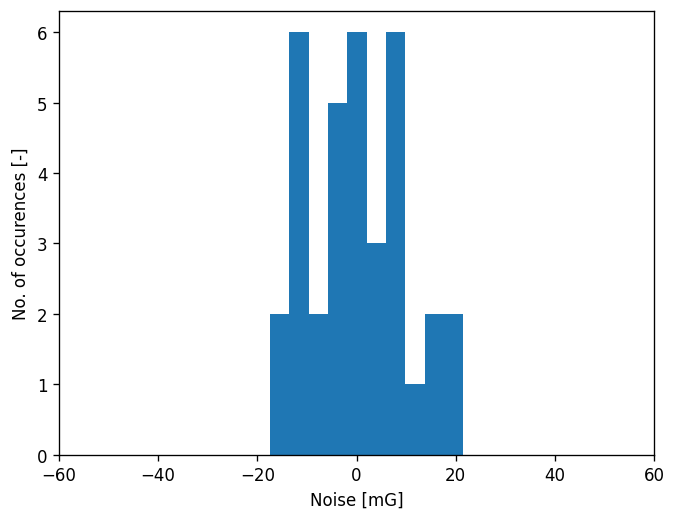

In [32]:
#********** Visualize noise data (low-power mode) **********#
# RMS noise level
lp_noise = np.std(data_lp[:,0])
print('--------------------------------------------------')
print('                LOW-POWER MODE                    ')
print('--------------------------------------------------')
print('RMS noise (LP): %1.3f mG' % lp_noise)
print('Datasheet: 9 mG')

# Histogram
fig = plt.figure(num = 0,dpi=120)
plt.hist(data_lp[:,0]-np.mean(data_lp[:,0]), bins=10)
plt.xlabel('Noise [mG]')
plt.xlim(-60, 60)
plt.ylabel('No. of occurences [-]')
plt.show()

--------------------------------------------------
               HIGH-POWER MODE                    
--------------------------------------------------
RMS noise (HP): 3.687 mG
Datasheet: 3 mG


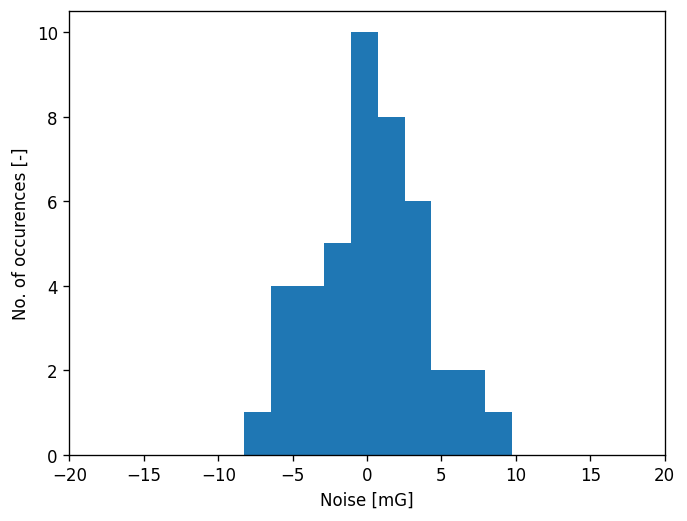

In [33]:
#********** Visualize noise data (high-performance mode) **********#
# RMS noise level
hp_noise = np.std(data_hp[:,0])
print('--------------------------------------------------')
print('               HIGH-POWER MODE                    ')
print('--------------------------------------------------')
print('RMS noise (HP): %1.3f mG' % hp_noise)
print('Datasheet: 3 mG')

# Histogram
fig = plt.figure(num = 1,dpi=120)
plt.hist(data_hp[:,0]-np.mean(data_hp[:,0]), bins=10)
plt.xlabel('Noise [mG]')
plt.xlim(-20, 20)
plt.ylabel('No. of occurences [-]')
plt.show()

3. Represent the one-sided power spectral density (PSD) as a function of frequency. To do so, you should be able to answer the following questions:
    * What steps must be followed to go from the raw signal to its one-sided PSD?
    * What are the units of the x- and y-axis?
    * What is the most suitable choice of scale for both axes? Linear or logarithmic?


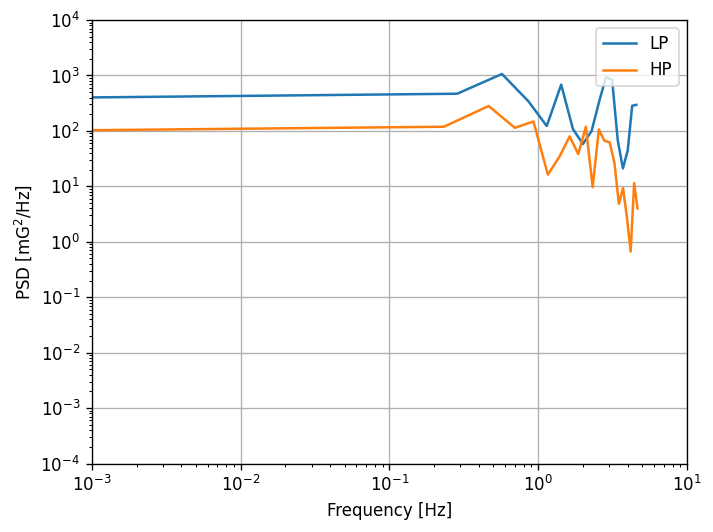

The most suitable choice of scale for both the x-axis and y-axis is logarithmic scale.


In [37]:
# Compute power spectral density (PSD)
def compute_psd(x, fs):
  # f     is the frequencies vector
  # psdx  is the Power spectral density
  #----- TO BE COMPLETED -----"
  f        = np.fft.fftfreq(len(x), 1/fs)
  f        = f[0:int(len(f)/2)]

  psdx     = np.abs(np.fft.fft(x))**2/fs

  psdx     = np.abs(psdx[0:int(len(psdx)/2)])
  #----- TO BE COMPLETED -----"

  return f, psdx

f_lp, psd_lp = compute_psd(data_lp[:,0]-np.mean(data_lp[:,0]), fs)
f_hp, psd_hp = compute_psd(data_hp[:,0]-np.mean(data_hp[:,0]), fs)

#********** Plot the power spectral density **********#
fig = plt.figure(num = 2,dpi=120)
plt.grid(True)
l1 = plt.plot(f_lp, psd_lp, label='LP')
l2 = plt.plot(f_hp, psd_hp, label='HP')
plt.legend(loc = "upper right")
plt.xlabel(r'Frequency [Hz]')
plt.xscale('log')
plt.xlim(1e-3, 1e1)
plt.ylabel(r'PSD [mG$^2$/Hz]')
plt.yscale('log')
plt.ylim(1e-4, 1e4)
plt.show()

print('The most suitable choice of scale for both the x-axis and y-axis is logarithmic scale.')

### Exercise 2: Altimeter noise characterization

The objectives of this exercise are (i) to visualize the pressure noise distribution and to understand how it translates into altitude noise, (ii) to evaluate the impact of environmental noise and device-to-device variations and (iii) to assess the altitude uncertainty related to these different sources.
In this exercise, we focus on the LPS22HH pressure sensor of the X_NUCLEO_IKS01A3 sensor board, which you have already used in the installation and hands-on session.

In [19]:
fs = 10 # Sampling frequency in Hz
Ts = 1/fs

#********** Utility functions **********#
def press_to_alt(p):
  h0 = 44330.77
  p0 = 1013.26
  a = 0.1902632
  h = h0 * (1 - (p/p0)**a)
  dh = -a * h0/p0 * (p/p0)**(a-1)
  return h, dh

def ema(din, beta):
  n = din.size
  dtemp = np.zeros(shape=(n,), dtype='float')
  dout = np.zeros(shape=(n,), dtype='float')
  for i in range(0,n):
    if (i == 0):
      dtemp[i] = (1-beta)*din[i]
    else:
      dtemp[i] = beta*dtemp[i-1] + (1-beta)*din[i]
    dout[i] = dtemp[i]/(1-beta**(i+1));
  return dout

1. Collect pressure and altitude data for the following sensor configuration:
* Output data rate (ODR): 100Hz;
* Low-noise configuration: Enabled (1);
* Device bandwidth: ODR/20 (3);
* Sampling rate: 10Hz, fixed by the timer TIM2.
The output data rate is the rate at which data is sampled by the ADC internal to the pressure sensor, while the sampling rate is the rate at which data is read from the pressure sensor output register by the main function.
![Figure2](figures\ex2_code_altimeter.png)

The file name of the measurement must be "data_lps22hh_altimeter_10Hz.txt" and you must place it in the "data" folder of this session directory.

In [38]:
# Load data
data = np.loadtxt('data/data_lps22hh_altimeter_10Hz.txt', skiprows=1, delimiter='\t')

2. To compute the pressure noise, consider two different cases: (i) remove the mean of all collected data and (ii) remove the mean computed by the exponential moving average function (provided to you) using $\beta$ = 0:95. In both cases, visualize the pressure noise by plotting an histogram of the collected data and describe its statistical distribution. Then, compute the pressure mean value and rms noise.

In [39]:
#********** Intrinsic noise **********#
press = data[:,0]
alt = data[:,1]
temp = data[:,2]

# Time vector
ndata = press.size
time = np.linspace(start = 0, stop = (ndata-1)/fs, num = ndata)

#----- TO BE COMPLETED -----"
# (i) pressure mean
press_mean         = 0
#(ii) exponential moving average
press_ema          = press
#----- TO BE COMPLETED -----"
    
# Remove mean of all collected data (i)
press_removed_mean = press - press_mean
# Remove exponential moving average (ii)  
press_removed_ema  = press - press_ema


--------------------------------------------------
          Pressure With and without EMA           
--------------------------------------------------


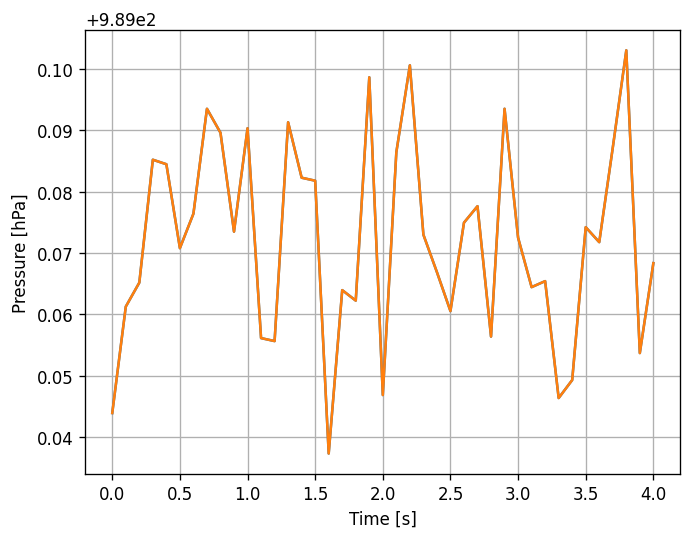

In [40]:
print('--------------------------------------------------')
print('          Pressure With and without EMA           ')
print('--------------------------------------------------')

# Pressure vs. time
fig = plt.figure(num = 0,dpi=120)
plt.grid(True)
plt.plot(time, press)
plt.plot(time, press_ema)
plt.xlabel('Time [s]')
plt.ylabel('Pressure [hPa]')
plt.show()

--------------------------------------------------
          PRESSURE NOISE BY REMOVING MEAN         
--------------------------------------------------
Pressure average:	 0.000 +/- 0.016 [hPa]


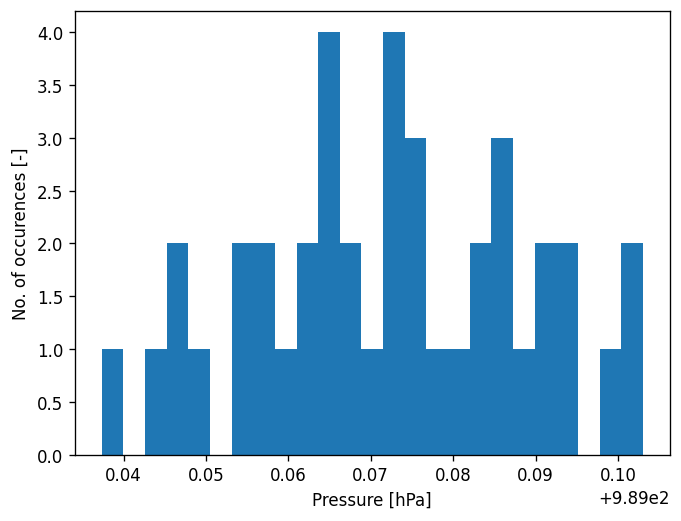

In [41]:
print('--------------------------------------------------')
print('          PRESSURE NOISE BY REMOVING MEAN         ')
print('--------------------------------------------------')
print('Pressure average:\t %1.3f +/- %1.3f [hPa]' % (press_mean, np.std(press_removed_mean)))

# Histogram
fig = plt.figure(num = 1,dpi=120)
plt.hist(press_removed_mean, bins = 25)
plt.xlabel('Pressure [hPa]')
plt.ylabel('No. of occurences [-]')
plt.show()

--------------------------------------------------
          PRESSURE NOISE BY REMOVING EMA          
--------------------------------------------------
Pressure average (EMA):	 989.072 +/- 0.000 [hPa]


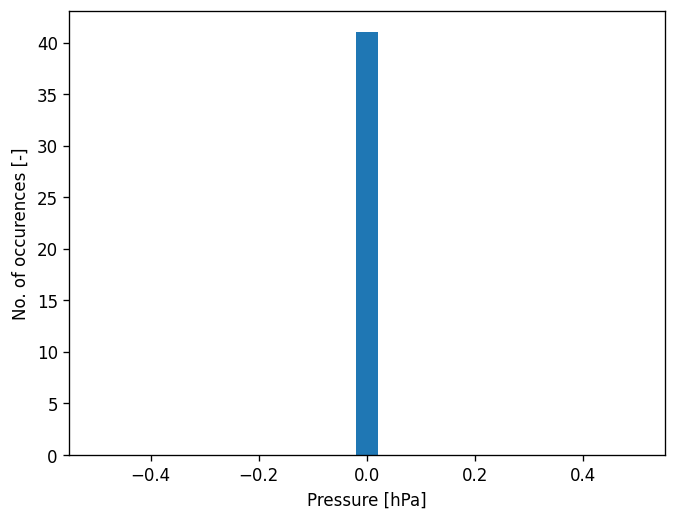

In [42]:
print('--------------------------------------------------')
print('          PRESSURE NOISE BY REMOVING EMA          ')
print('--------------------------------------------------')
print('Pressure average (EMA):\t %1.3f +/- %1.3f [hPa]' % (np.mean(press_ema), np.std(press_removed_ema)))

# Histogram
fig = plt.figure(num = 2,dpi=120)
plt.hist(press_removed_ema, bins = 25)
plt.xlabel('Pressure [hPa]')
plt.ylabel('No. of occurences [-]')
plt.show()

3. From a purely mathematical point of view, compute how the pressure rms noise translates into altitude noise, knowing that altitude is computed from pressure using the adiabatic height formula [[2](#references)]
![Figure3](figures\ex2_equation.png)
where $p$ is the pressure in hPa, $p_0$ = 1013:26 hPa is the pressure at sea level and h is the altitude in meters. More specifically, we ask you to:
*  Compute the altitude corresponding to $p$ = $\mu_p$ - $\sigma_p$, $p$ = $\mu_p$ and $p$ = $\mu_p$ + $\sigma_p$ where $\mu_p$ and $\sigma_p$ are the pressure mean and rms noise computed previously from the experimental data, by removing the mean computed by the exponential moving average. Does your result match with the experimental altitude rms noise? What is the statistical distribution of the altitude noise?
* Repeat the same computation by using $\mu_p$ = 1013.26 hPa, corresponding to the pressure at sea level, and the same $\sigma_p$ as for the previous question. Is there a difference in altitude noise? If yes, how can you explain this difference?

In [43]:

#----- TO BE COMPLETED -----"
mu_p    = 100
sigma_p = 0
#----- TO BE COMPLETED -----"


# Raw data
h_min, dh = press_to_alt(mu_p + sigma_p)
h_mid, dh = press_to_alt(mu_p)
h_max, dh = press_to_alt(mu_p - sigma_p)

print('--------------------------------------------------');
print('Raw data : min. = %1.6f \t, mid. = %1.6f \t, max = %1.6f [m] \t (%1.6f/+%1.6f)' % (h_min, h_mid, h_max, h_min-h_mid, h_max-h_mid));

# Sea level
mu_p_sea = 1013.26

# Pressure at sea level in hPa
h_min, dh = press_to_alt(mu_p_sea + sigma_p)
h_mid, dh = press_to_alt(mu_p_sea)
h_max, dh = press_to_alt(mu_p_sea - sigma_p)


print('Sea level: min. = %1.6f \t, mid. = %1.6f \t, max = %1.6f [m] \t (%1.6f/+%1.6f)' % (h_min, h_mid, h_max, h_min-h_mid, h_max-h_mid));
print('--------------------------------------------------');

--------------------------------------------------
Raw data : min. = 15797.365159 	, mid. = 15797.365159 	, max = 15797.365159 [m] 	 (0.000000/+0.000000)
Sea level: min. = 0.000000 	, mid. = 0.000000 	, max = 0.000000 [m] 	 (0.000000/+0.000000)
--------------------------------------------------


4. Atmospheric pressure is strongly related to weather, resulting in an environmental noise on the altitude measurement. Pressure data for Louvain-la-Neuve from September 12, 2020 to September 26, 2020 was downloaded from [[3](#references)] and is provided to you. Based on the min. and max. pressure value, compute the error (variation) in the perceived altitude due to environmental noise.

--------------------------------------------------
Minimal pressure observed : 0.000000 [hPa]
Corresponding altitude    : 0.000000 [m]  
--------------------------------------------------
Maximal pressure observed : 0.000000 [hPa]
Corresponding altitude    : 0.000000 [m]  
--------------------------------------------------


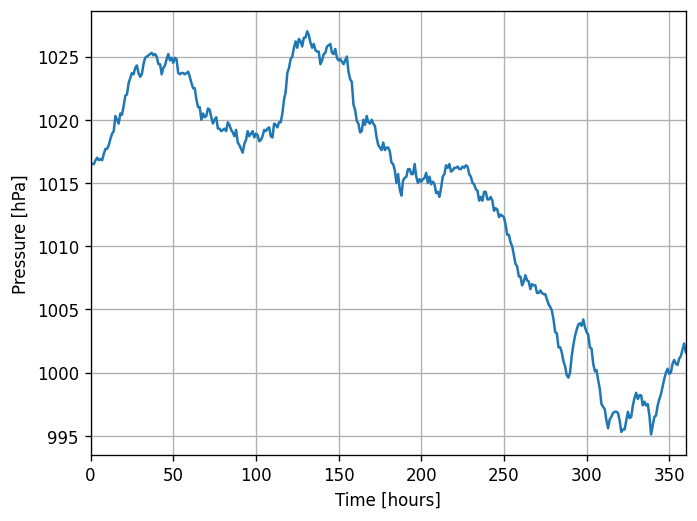

In [44]:
#********** Environmental noise **********#
# Load data
pressure = np.loadtxt('data/data_lps22hh_altimeter_environment.txt', skiprows=1, delimiter='\t')
hours = np.linspace(start=1, stop=pressure.size, num=pressure.size)

#----- TO BE COMPLETED -----"
minimal_pressure = 0
altitude_minimal_pressure = 0

maximal_pressure = 0
altitude_maximal_pressure = 0
#----- TO BE COMPLETED -----"

# Pressure vs. time
fig = plt.figure(num = 2,dpi=120)
plt.plot(hours, pressure)
plt.grid(True)
plt.xlabel('Time [hours]')
plt.xlim(0, 360)
plt.ylabel('Pressure [hPa]')


print('--------------------------------------------------');
print('Minimal pressure observed : %1.6f [hPa]' % (minimal_pressure))
print('Corresponding altitude    : %1.6f [m]  ' %(altitude_minimal_pressure))
print('--------------------------------------------------');
print('Maximal pressure observed : %1.6f [hPa]' % (maximal_pressure))
print('Corresponding altitude    : %1.6f [m]  ' %(altitude_maximal_pressure))
print('--------------------------------------------------');
plt.show()

5. To assess device-to-device variations, data collected by the LELEC2811 groups in September 2019 is provided to you, together with a Python code to analyze it. What is the standard deviation of the pressure and altitude measurements provided by the groups?

--------------------------------------------------
Device-to-device variations
--------------------------------------------------
Mean pressure:		 0.000000 [hPa]
Mean pressure std.:	 0.000000 [hPa]
Std. pressure (D2D):	 0.000000 [hPa]
--------------------------------------------------
Mean altitude:		 0.000000 [m]
Mean altitude std.:	 0.000000 [m]
Std. altitude (D2D):	 0.000000 [m]
--------------------------------------------------


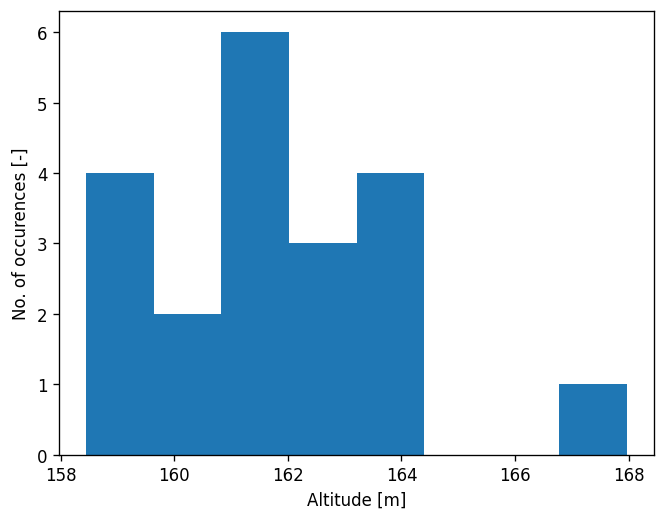

In [45]:
#********** Device-to-device variations **********#
# Load data
data = np.loadtxt('data/data_lps22hh_altimeter_d2d.txt', skiprows=1, delimiter='\t');

# Transform from table to arrays
ngroups = data[:,0]
altitude = data[:,3]
altitude_noise = data[:,4]
pressure = data[:,1]
press_noise = data[:,2]

# Plot results
fig = plt.figure(num = 3,dpi=120)
plt.hist(altitude, bins=8)
plt.xlabel('Altitude [m]')
plt.ylabel('No. of occurences [-]')

# Compute results
#----- TO BE COMPLETED -----"
# Pressure
mean_pressure = 0
mean_press_noise = 0
std_pressure = 0

# Altitude
mean_alt = 0
mean_alt_noise = 0
std_alt = 0
#----- TO BE COMPLETED -----"

# Display results
print('--------------------------------------------------')
print('Device-to-device variations')
print('--------------------------------------------------')
print('Mean pressure:\t\t %1.6f [hPa]' % mean_pressure)
print('Mean pressure std.:\t %1.6f [hPa]'% mean_press_noise)
print('Std. pressure (D2D):\t %1.6f [hPa]' % std_pressure)
print('--------------------------------------------------')
print('Mean altitude:\t\t %1.6f [m]' % mean_alt)
print('Mean altitude std.:\t %1.6f [m]' % mean_alt_noise)
print('Std. altitude (D2D):\t %1.6f [m]' % std_alt)
print('--------------------------------------------------')
plt.show()

6. Finally, assess the uncertainty related to each source (intrinsic noise, environmental noise and device-to-device variations). For the intrinsic noise and the device-to-device variations, you can compute the uncertainty as $(+/-)3 \sigma_h$,
where $\sigma_h$ is the altitude rms noise or standard deviation.

In [46]:
#----- TO BE COMPLETED -----"
delta_h_d2d = 3*0
delta_h_int = 3*0
delta_h_env = 0
#----- TO BE COMPLETED -----"

print('--------------------------------------------------')
print('            ALTITUDE UNCERTAINTY                  ')
print('--------------------------------------------------')
print('Intrinsic noise     : +/- %1.6f [m]' % delta_h_int)
print('Environmental noise : +/- %1.6f [m]' % delta_h_env)
print('D2D variations      :     %1.6f [m]' % delta_h_d2d)
print('--------------------------------------------------')

--------------------------------------------------
            ALTITUDE UNCERTAINTY                  
--------------------------------------------------
Intrinsic noise     : +/- 0.000000 [m]
Environmental noise : +/- 0.000000 [m]
D2D variations      :     0.000000 [m]
--------------------------------------------------


# References
<a id='references'></a>
[1] STMicroelectronics, "Digital output magnetic sensor: ultra-low-power, high-performance 3-axis magnetometer",
LIS2MDL datasheet, May 2017 [Revised Nov. 2018].

[2] G. Gerlich and R. D. Tscheuschner, "On The Barometric Formulas And Their Derivation From Hydrodynamics And
Thermodynamics", arXiv:1003.1508 [physics.ao-ph], Mar. 2010.

[3] Meteoblue, "Weather in Louvain-la-Neuve". [Online]. Available: https://www.meteoblue.com/en/weather/
week/louvain-la-neuve_belgium_2792073. [Accessed Sep. 26, 2020].

